# Engineering Modeling and Design Optimization

## Modeling Noisy Data using Regression Kriging

In [1]:
import numpy as np
from smt.surrogate_models import KRG
from smt.problems import TorsionVibration
from smt.sampling_methods import LHS, FullFactorial
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from scipy.stats import norm

In [12]:
# Defining the noisy forrester function
forrester = lambda x: (6*x-2)**2*np.sin(12*x-4) + norm.rvs(scale = 1.0, size=x.shape)

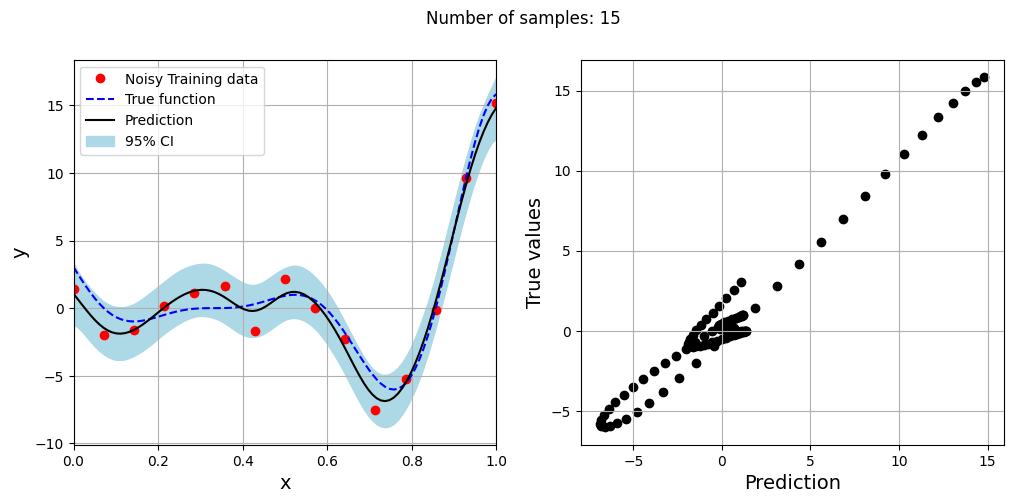

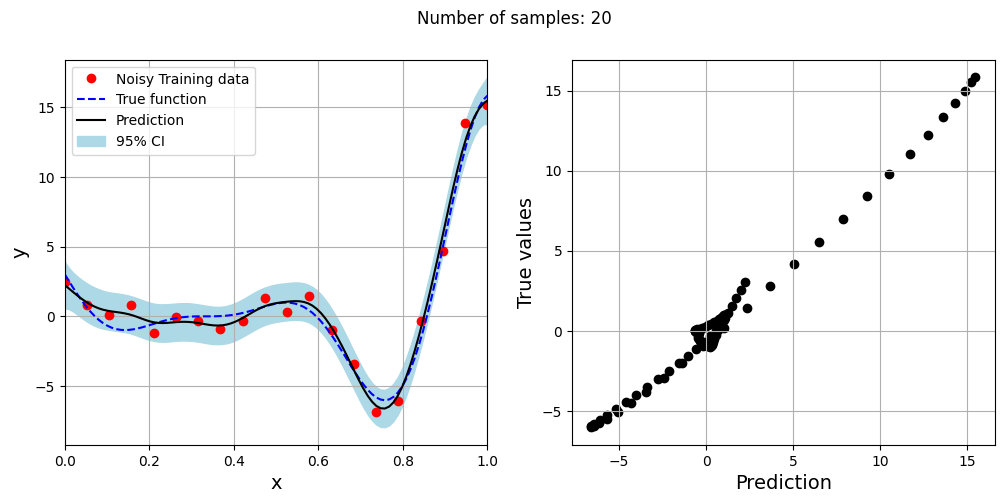

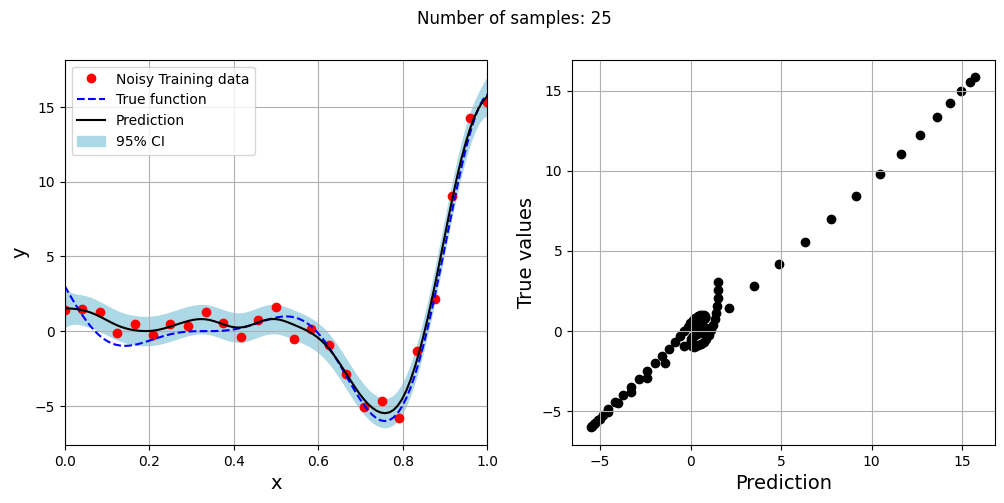

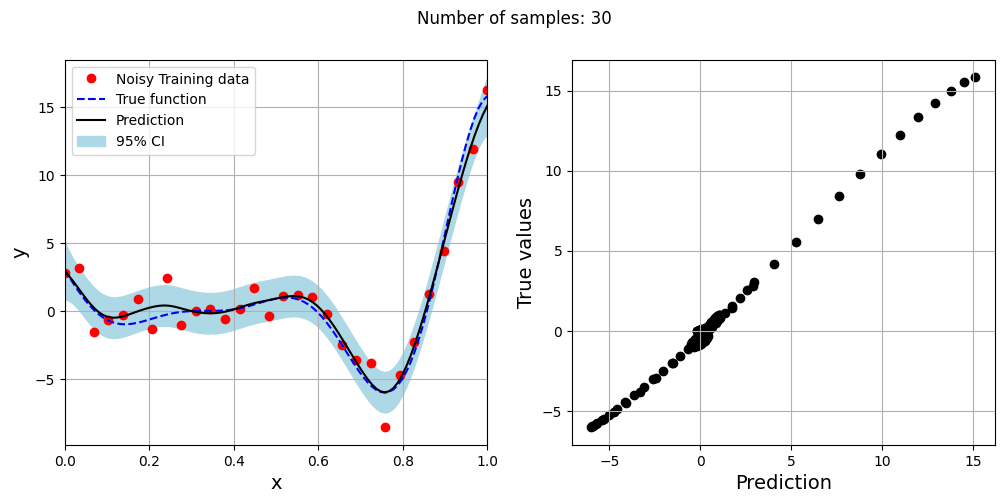

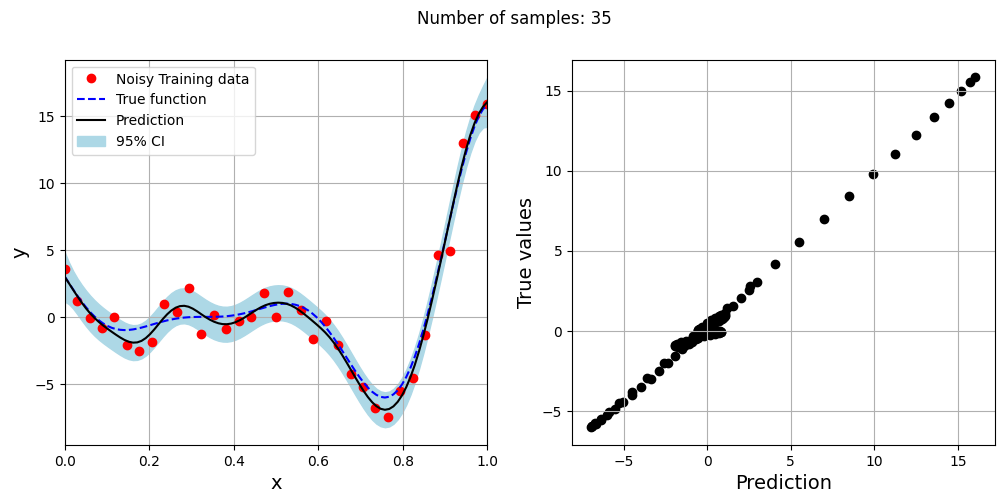

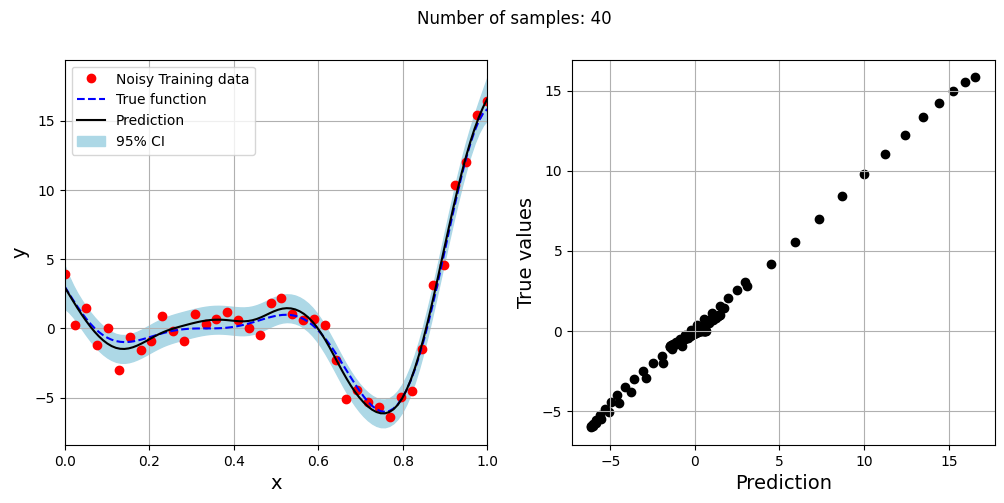

In [16]:
# Plotting data
xplot = np.linspace(0, 1, 100)
yplot = (6*xplot-2)**2 * np.sin(12*xplot-4)

# Creating array of training sample sizes
samples = np.array([15,20,25,30,35,40])

# Initializing nrmse list
nrmse = []

# Fitting with different sample size
for sample in samples:
    
    xtrain = np.linspace(0, 1, sample)
    ytrain = forrester(xtrain)
    
    # Fitting the kriging
    sm = KRG(theta0=[1e-2], corr='matern52', theta_bounds=[1e-6, 1e2], print_global=False, eval_noise = True)
    sm.set_training_values(xtrain, ytrain)
    sm.train()
    
    # Predict at test values
    yplot_pred = sm.predict_values(xplot).reshape(-1,)
    yplot_var = sm.predict_variances(xplot).reshape(-1,)

    # Calculating average nrmse
    nrmse.append(np.sqrt(mean_squared_error(yplot, yplot_pred)) / np.ptp(yplot))
    
    # Plotting prediction
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    
    ax[0].plot(xtrain, ytrain, 'ro', label='Noisy Training data')
    ax[0].plot(xplot, yplot, 'b--', label='True function')
    ax[0].plot(xplot, yplot_pred, 'k', label='Prediction')
    ax[0].fill_between(xplot, yplot_pred - 2*np.sqrt(yplot_var), yplot_pred + 2*np.sqrt(yplot_var), color='lightblue', label='95% CI')
    ax[0].set_xlim((0, 1))
    ax[0].set_xlabel("x", fontsize=14)
    ax[0].set_ylabel("y", fontsize=14)
    ax[0].grid()
    ax[0].legend()
    
    ax[1].scatter(yplot_pred, yplot, c="k")
    ax[1].set_xlabel("Prediction", fontsize=14)
    ax[1].set_ylabel("True values", fontsize=14)
    ax[1].grid()
    
    fig.suptitle("Number of samples: {}".format(sample))

In [4]:
# Defining the torsion vibration problem
ndim = 15
problem = TorsionVibration(ndim=ndim)

# Defining noisy version of the problem 
noisy_problem = lambda x: problem(x) + norm.rvs(scale = 1.0, size=1)

In [5]:
# Calculating NRMSE with and without noisy training data

# Creating array of training sample sizes
samples = np.array([10,20,30,40,50,60,70,80])

# Initializing nrmse list
nrmse = []
nrmse_noisy = []

# Creating testing data for the problem
test_sampler = FullFactorial(xlimits=problem.xlimits)
num_test = 50
xtest = test_sampler(num_test)
ytest = problem(xtest)

# Fitting with different sample size
train_sampler = LHS(xlimits=problem.xlimits, criterion="ese")
for sample in samples:
    
    num_train = sample
    xtrain = train_sampler(num_train)
    ytrain = problem(xtrain)
    noisy_ytrain = noisy_problem(xtrain)
    
    # Fitting the kriging
    sm = KRG(theta0=[1e-2], corr='squar_exp', theta_bounds=[1e-6, 1e2], print_global=False)
    sm.set_training_values(xtrain, ytrain)
    sm.train()
    
    # Fitting the kriging to noisy data
    sm_noisy = KRG(theta0=[1e-2], corr='squar_exp', theta_bounds=[1e-6, 1e2], print_global=False, eval_noise = True)
    sm_noisy.set_training_values(xtrain, noisy_ytrain)
    sm_noisy.train()
    
    # Predict at test values
    ypred = sm.predict_values(xtest)
    noisy_ypred = sm_noisy.predict_values(xtest)

    # Calculating average nrmse
    nrmse.append(np.sqrt(mean_squared_error(ytest, ypred)) / np.ptp(ytest))
    nrmse_noisy.append( np.sqrt(mean_squared_error(ytest, noisy_ypred)) / np.ptp(ytest) )

Text(0, 0.5, 'Normalized RMSE')

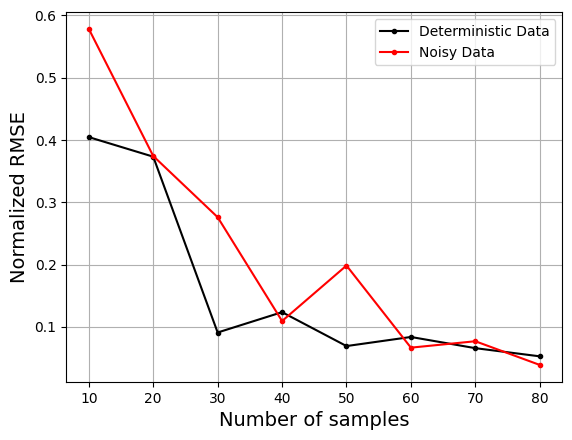

In [6]:
# Plotting NMRSE
fig, ax = plt.subplots()
ax.plot(samples, np.array(nrmse), c="k", marker=".", label = 'Deterministic Data')
ax.plot(samples, np.array(nrmse_noisy), c="r", marker=".", label = 'Noisy Data')
ax.grid(which="both")
ax.legend()
ax.set_xlabel("Number of samples", fontsize=14)
ax.set_ylabel("Normalized RMSE", fontsize=14)

## Feature scaling for engineering modeling 

In [7]:
# Minmax scaling
minmax_scaler = MinMaxScaler()

# Standard scaling
std_scaler = StandardScaler()

In [8]:
# Creating a model with and without scaling
num = 40
xtrain = train_sampler(num)
ytrain = problem(xtrain)

xtrain_scaled = minmax_scaler.fit_transform(xtrain)

In [9]:
# Fitting the kriging using scaled data
sm_scaled = KRG(theta0=[1e-2], corr='squar_exp', theta_bounds=[1e-6, 1e2], print_global=False)
sm_scaled.set_training_values(xtrain_scaled, ytrain)
sm_scaled.train()

# Fitting the kriging using unscaled data
sm = KRG(theta0=[1e-2], corr='squar_exp', theta_bounds=[1e-6, 1e2], print_global=False)
sm.set_training_values(xtrain, ytrain)
sm.train()

# Predicting on test data
ypred_scaled = sm_scaled.predict_values(minmax_scaler.transform(xtest))
ypred = sm.predict_values(xtest)

print("NRMSE for scaled data:", np.sqrt(mean_squared_error(ytest, ypred_scaled)) / np.ptp(ytest))
print("NRMSE for unscaled data:", np.sqrt(mean_squared_error(ytest, ypred)) / np.ptp(ytest))

NRMSE for scaled data: 0.09674368894133425
NRMSE for unscaled data: 0.09674368894128359
